In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
import joblib

In [72]:
df = pd.read_csv("air-quality-in-nairobi.csv") 

In [73]:
df.head()

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,128;SDS011;68;-1.376;36.929;2019-09-01T00:00:0...
1,128;SDS011;68;-1.376;36.929;2019-09-01T00:00:0...
2,127;DHT22;68;-1.376;36.929;2019-09-01T00:00:05...
3,127;DHT22;68;-1.376;36.929;2019-09-01T00:00:05...
4,79;SDS011;30;-1.290;36.777;2019-09-01T00:00:06...


In [111]:
# Load with semicolon as separator
df = pd.read_csv("air-quality-in-nairobi.csv", sep=";")
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P2,7.20
1,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P1,10.03
2,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,humidity,99.90
3,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,temperature,16.10
4,79,SDS011,30,-1.290,36.777,2019-09-01T00:00:06.128592+00:00,P2,6.93


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719404 entries, 0 to 719403
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    719404 non-null  int64  
 1   sensor_type  719404 non-null  object 
 2   location     719404 non-null  int64  
 3   lat          719404 non-null  float64
 4   lon          719404 non-null  float64
 5   timestamp    719404 non-null  object 
 6   value_type   719404 non-null  object 
 7   value        719404 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 43.9+ MB


In [113]:
# parse timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

In [ ]:
Steps Overview

Load & reshape (long → wide)

Clean (drop unused columns, handle missing values)

Create AQI labels (Healthy=1, Unhealthy=0)

EDA (distributions, boxplots, pairplots, correlations)

Preprocessing (features, encode, split, scale, SMOTE)

Train & evaluate multiple models

Hyperparameter tuning (Gradient Boosting)

Feature importance

Learning curve

Save model, scaler, encoder

In [114]:
# pivot so each value_type becomes its own column; group by timestamp & location
df_wide = df.pivot_table(
    index=['timestamp','location'],
    columns='value_type',
    values='value',
    aggfunc='mean'
).reset_index()

# Flatten columns
df_wide.columns.name = None
df_wide = df_wide.rename_axis(None, axis=1)
df_wide.head()

,timestamp,location,P1,P2,humidity,temperature
0,2019-09-01 00:00:02.236776+00:00,68,10.03,7.20,NaN,NaN
1,2019-09-01 00:00:05.613250+00:00,68,NaN,NaN,99.9,16.1
2,2019-09-01 00:00:06.128592+00:00,30,10.40,6.93,NaN,NaN
3,2019-09-01 00:00:08.844578+00:00,30,NaN,NaN,99.9,17.3
4,2019-09-01 00:00:09.836965+00:00,59,0.10,0.10,NaN,NaN


In [78]:
df_wide.shape

(359686, 6)

In [79]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   timestamp    359686 non-null  datetime64[ns, UTC]
 1   location     359686 non-null  int64              
 2   P1           186444 non-null  float64            
 3   P2           186444 non-null  float64            
 4   humidity     173257 non-null  float64            
 5   temperature  173257 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 16.5 MB


In [117]:
df_wide.isnull().sum()

timestamp              0
location               0
P1                173242
P2                173242
humidity          186429
temperature       186429
AQI_Category      173242
AQI_Binary             0
AQI_Binary_Num         0
dtype: int64

In [20]:
# Numerical columns
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns:", num_cols)

# Categorical columns
cat_cols = df_wide.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", cat_cols)


Numerical Columns: ['location', 'P1', 'P2', 'humidity', 'temperature', 'AQI_Binary_Num']
Categorical Columns: ['AQI_Category', 'AQI_Binary']


In [116]:
# Create AQI labels

def pm25_to_aqi(pm):
    if pd.isna(pm):
        return None
    pm = float(pm)
    if pm <= 12.0:
        return "Good"
    elif pm <= 35.4:
        return "Moderate"
    elif pm <= 55.4:
        return "Unhealthy-Sensitive"
    elif pm <= 150.4:
        return "Unhealthy"
    elif pm <= 250.4:
        return "Very Unhealthy"
    else:
        return "Hazardous"

df_wide['AQI_Category'] = df_wide['P2'].apply(pm25_to_aqi)

def simplify_category(cat):
    if cat in ["Good","Moderate"]:
        return "Healthy"
    else:
        return "Unhealthy"

df_wide['AQI_Binary'] = df_wide['AQI_Category'].apply(simplify_category)
df_wide['AQI_Binary_Num'] = df_wide['AQI_Binary'].map({'Healthy':1, 'Unhealthy':0})

print(df_wide[['P2','AQI_Category','AQI_Binary','AQI_Binary_Num']].head())
print("Class counts:\n", df_wide['AQI_Binary'].value_counts())


     P2 AQI_Category AQI_Binary  AQI_Binary_Num
0  7.20         Good    Healthy               1
1   NaN         None  Unhealthy               0
2  6.93         Good    Healthy               1
3   NaN         None  Unhealthy               0
4  0.10         Good    Healthy               1
Class counts:
 AQI_Binary
Healthy      181366
Unhealthy    178320
Name: count, dtype: int64


In [118]:
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df_wide[col].unique())
    print("Unique count:", df_wide[col].nunique())



Column: AQI_Category
['Good' None 'Moderate' 'Unhealthy' 'Unhealthy-Sensitive' 'Hazardous'
 'Very Unhealthy']
Unique count: 6

Column: AQI_Binary
['Healthy' 'Unhealthy']
Unique count: 2


In [119]:
df_wide.describe()

,location,P1,P2,humidity,temperature,AQI_Binary_Num
count,359686.000000,186444.000000,186444.000000,173257.000000,173257.000000,359686.000000
mean,50.218883,21.653899,11.245230,68.480078,22.996220,0.504234
std,18.575967,34.982505,14.313417,21.373744,9.949977,0.499983
min,7.000000,0.000000,0.000000,22.700000,11.800000,0.000000
25%,29.000000,9.020000,4.870000,51.699829,18.800000,0.000000
50%,61.000000,14.850000,7.700000,65.900000,21.700000,1.000000
75%,68.000000,24.370000,12.930000,89.100000,24.800000,1.000000
max,70.000000,1999.900000,999.900000,99.998474,99.998474,1.000000


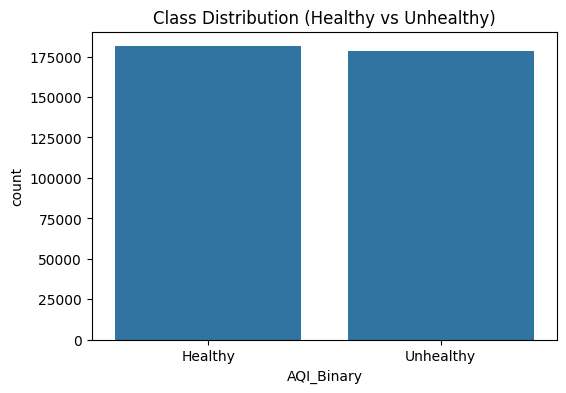

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_wide, x='AQI_Binary')
plt.title("Class Distribution (Healthy vs Unhealthy)")
plt.show()

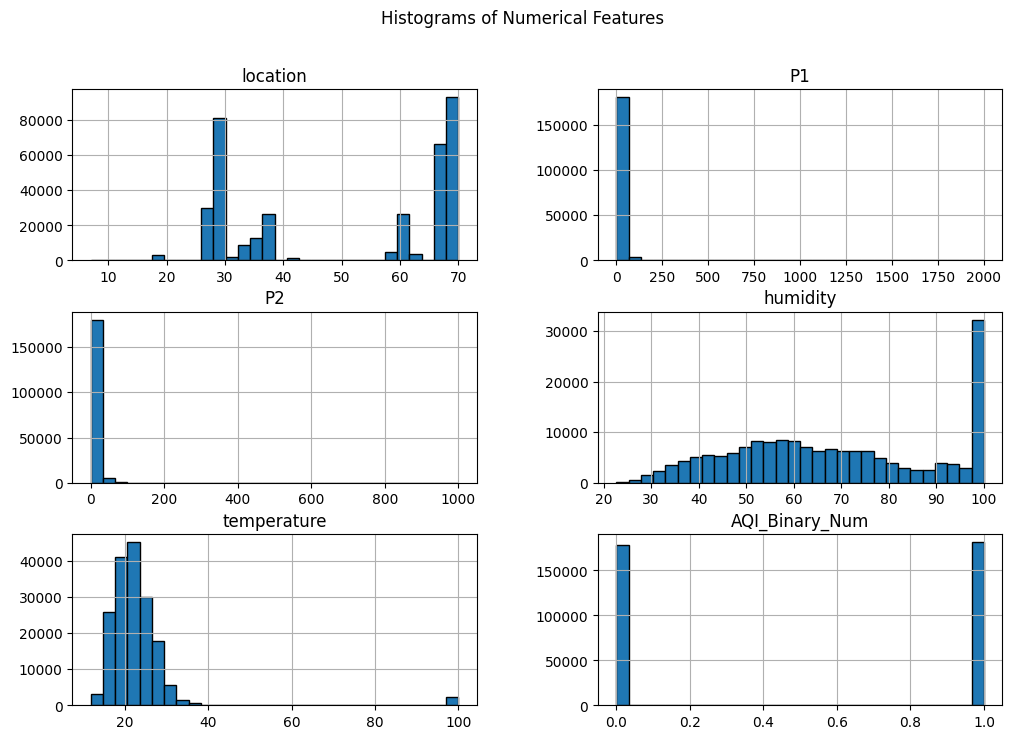

In [18]:
# Numerical columns (excluding timestamp, location, and categorical)
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()

# Histograms
df_wide[num_cols].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

<Figure size 1200x600 with 0 Axes>

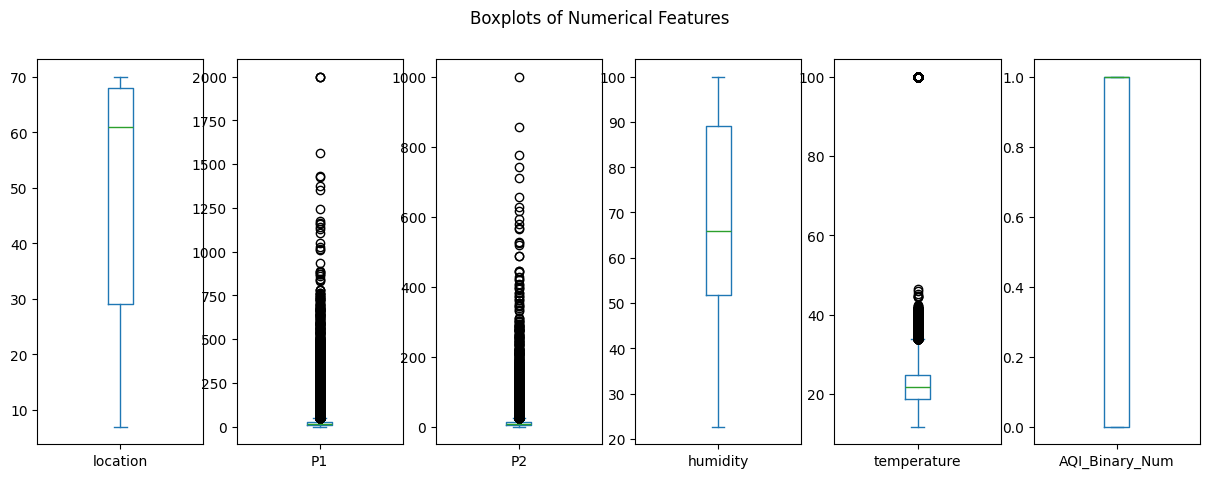

In [19]:
# Boxplots
plt.figure(figsize=(12, 6))
df_wide[num_cols].plot(kind='box', subplots=True, layout=(1, len(num_cols)), figsize=(15, 5), sharey=False)
plt.suptitle("Boxplots of Numerical Features")
plt.show()

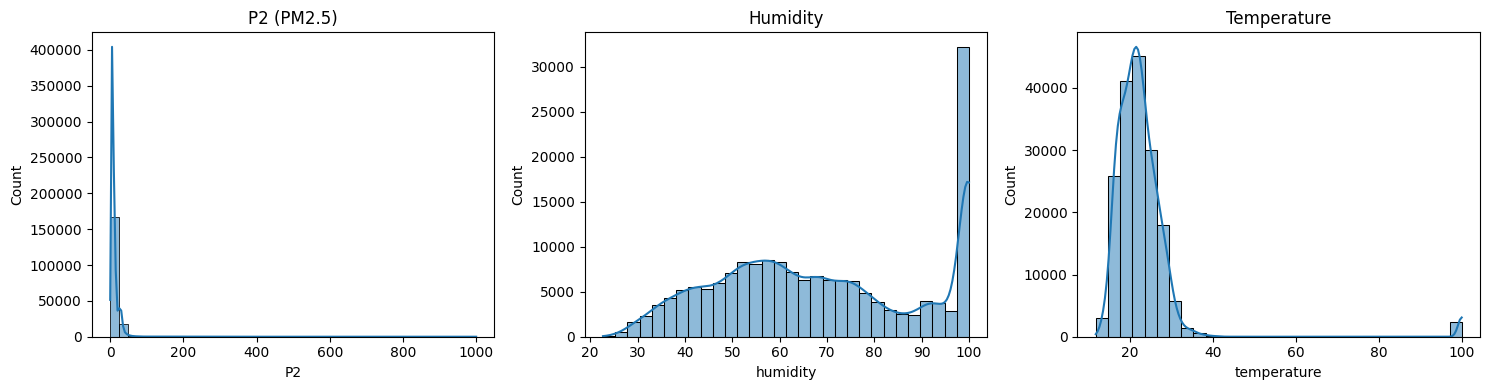

In [14]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df_wide['P2'], bins=40, kde=True, ax=axes[0]).set_title('P2 (PM2.5)')
sns.histplot(df_wide['humidity'], bins=30, kde=True, ax=axes[1]).set_title('Humidity')
sns.histplot(df_wide['temperature'], bins=30, kde=True, ax=axes[2]).set_title('Temperature')
plt.tight_layout()
plt.show()

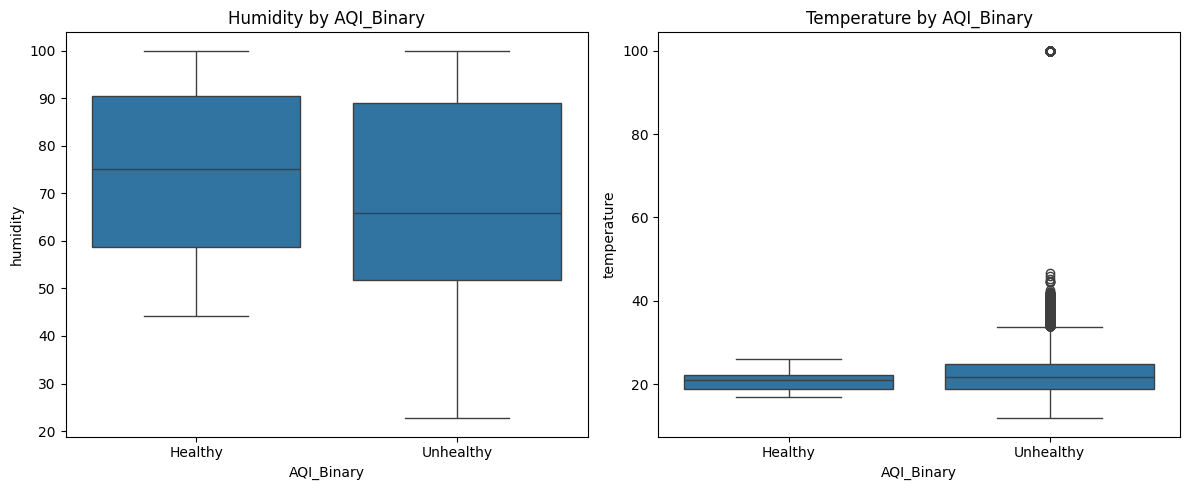

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(data=df_wide, x='AQI_Binary', y='humidity', ax=axes[0])
axes[0].set_title('Humidity by AQI_Binary')
sns.boxplot(data=df_wide, x='AQI_Binary', y='temperature', ax=axes[1])
axes[1].set_title('Temperature by AQI_Binary')
plt.tight_layout()
plt.show()

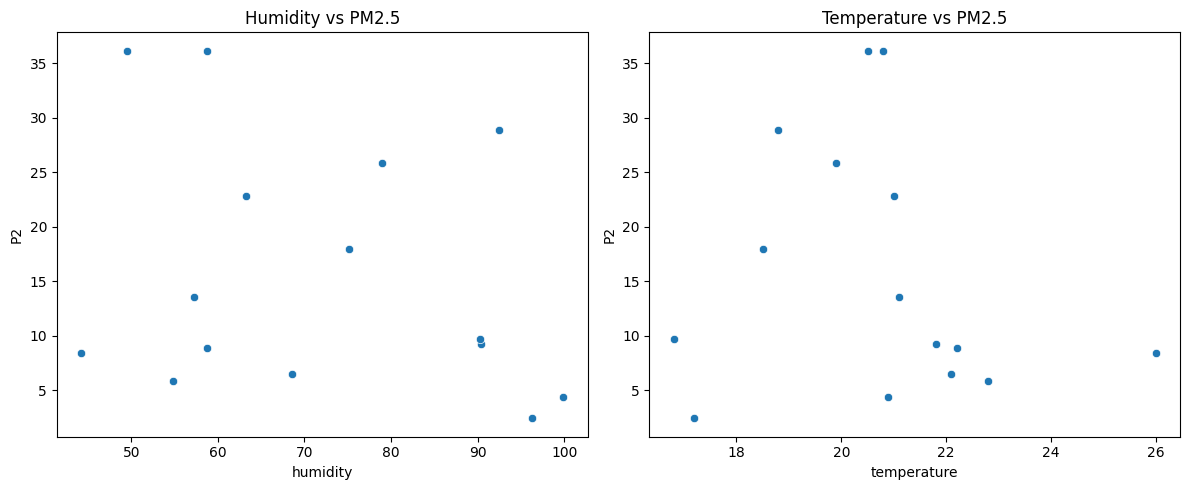

In [25]:
# Example scatter plots between features and P2 (PM2.5)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='humidity', y='P2', data=df_wide)
plt.title("Humidity vs PM2.5")

plt.subplot(1, 2, 2)
sns.scatterplot(x='temperature', y='P2', data=df_wide)
plt.title("Temperature vs PM2.5")

plt.tight_layout()
plt.show()


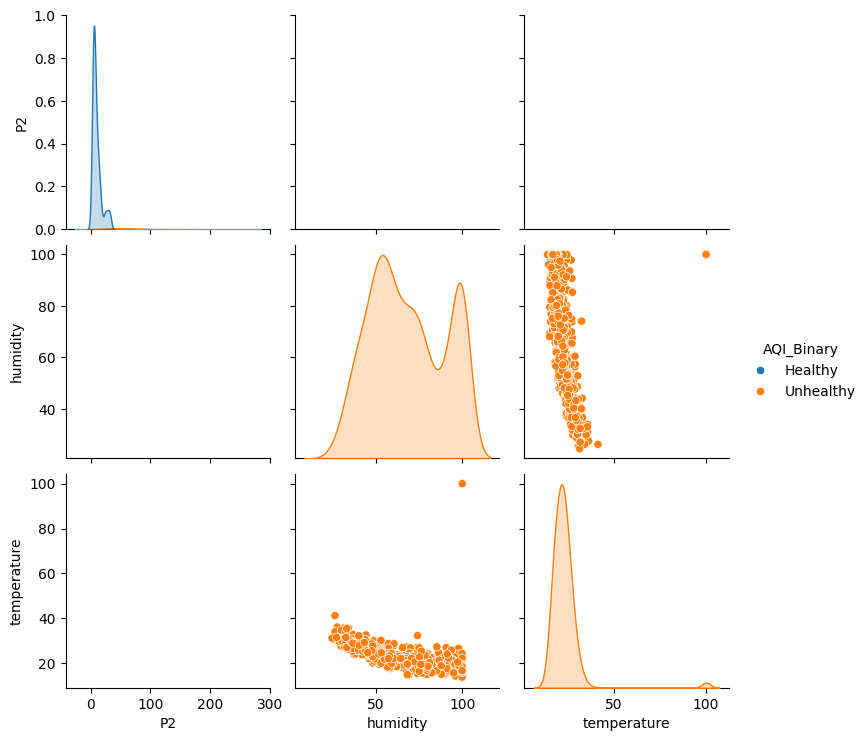

In [16]:
sample = df_wide.sample(n=min(2000, len(df_wide)), random_state=42)
sns.pairplot(sample[['P2','humidity','temperature','AQI_Binary']], hue='AQI_Binary', diag_kind='kde')
plt.show()

In [120]:
df_wide.columns

Index(['timestamp', 'location', 'P1', 'P2', 'humidity', 'temperature',
       'AQI_Category', 'AQI_Binary', 'AQI_Binary_Num'],
      dtype='object')

In [121]:
# Drop columns not useful for prediction
df_wide.drop(["timestamp", "P1", "AQI_Category", "AQI_Binary"], axis=1, inplace=True)

# Check remaining columns
print("Remaining columns:", df_wide.columns.tolist())
print(df_wide.info())


Remaining columns: ['location', 'P2', 'humidity', 'temperature', 'AQI_Binary_Num']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   location        359686 non-null  int64  
 1   P2              186444 non-null  float64
 2   humidity        173257 non-null  float64
 3   temperature     173257 non-null  float64
 4   AQI_Binary_Num  359686 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 13.7 MB
None


In [122]:
df_wide.isnull().sum()

location               0
P2                173242
humidity          186429
temperature       186429
AQI_Binary_Num         0
dtype: int64

In [123]:
# Impute missing humidity and temperature with their median
for col in ['humidity', 'temperature']:
    if df_wide[col].isnull().any():
        median_val = df_wide[col].median()
        df_wide[col] = df_wide[col].fillna(median_val)

print(df_wide[['humidity','temperature']].isnull().sum())


humidity       0
temperature    0
dtype: int64


In [124]:
# Impute 'P2' with median
df_wide['P2'] = df_wide['P2'].fillna(df_clean['P2'].median())

In [125]:
df_wide.isnull().sum()

location          0
P2                0
humidity          0
temperature       0
AQI_Binary_Num    0
dtype: int64

In [126]:


# Function to cap outliers using IQR
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Replace values outside bounds with the bounds
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    return df

# Apply capping to humidity and temperature
df_capped = df_wide.copy()
for col in ['humidity', 'temperature']:
    df_capped = cap_outliers_iqr(df_capped, col)

print("Outliers capped for humidity and temperature.")
print(df_capped[['humidity','temperature']].describe())


Outliers capped for humidity and temperature.
           humidity   temperature
count  3.596860e+05  3.596860e+05
mean   6.590000e+01  2.170000e+01
std    2.842175e-14  3.552719e-15
min    6.590000e+01  2.170000e+01
25%    6.590000e+01  2.170000e+01
50%    6.590000e+01  2.170000e+01
75%    6.590000e+01  2.170000e+01
max    6.590000e+01  2.170000e+01


In [127]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Use sparse_output=False for newer sklearn
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit + transform
loc_encoded = encoder.fit_transform(df_wide[['location']])

# Get new column names
loc_cols = encoder.get_feature_names_out(['location'])

# Build encoded DataFrame
loc_df = pd.DataFrame(loc_encoded, columns=loc_cols, index=df_wide.index)

# Drop old location and join encoded
df_encoded = pd.concat([df_wide.drop(columns=['location']), loc_df], axis=1)

print("Final columns after encoding:")
print(df_encoded.columns.tolist())


Final columns after encoding:
['P2', 'humidity', 'temperature', 'AQI_Binary_Num', 'location_7', 'location_18', 'location_27', 'location_28', 'location_29', 'location_30', 'location_31', 'location_34', 'location_35', 'location_37', 'location_41', 'location_51', 'location_59', 'location_60', 'location_61', 'location_63', 'location_67', 'location_68', 'location_69', 'location_70']


### Define features & target

In [128]:
# # Define features (X) and target (y)
X = df_encoded.drop(columns=['AQI_Binary_Num'])
y = df_encoded['AQI_Binary_Num']

### Split the data

In [129]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Scaling

In [131]:
# identify columns
num_standard = ['humidity']         # normal → StandardScaler
num_robust = ['temperature', 'P2']  # skew/outliers → RobustScaler
onehot_cols = [c for c in X.columns if c.startswith('location_')]  # already one-hot

# preprocessing
preprocessor = ColumnTransformer([
    ('std', StandardScaler(), num_standard),
    ('rob', RobustScaler(), num_robust),
    ('pass', 'passthrough', onehot_cols)
])


### Training and Evaluation

In [66]:
from sklearn.impute import SimpleImputer

In [3]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),  # include scaling/imputation here
        ('classifier', model)
    ])
    
    # Fit the model
    pipe.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print("="*60)
    print(f"Train Accuracy: {train_acc:.2f}")
    print(f"Test Accuracy : {test_acc:.2f}\n")
    
    # Classification Reports
    print("Classification Report (Training Set):")
    print(classification_report(y_train, y_train_pred))
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix for Test Set
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Color map: correct=green, incorrect=red
    colors = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j:
                colors[i, j] = 'green'
            else:
                colors[i, j] = 'red'
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=None, cbar=False, 
                annot_kws={"size":14}, square=True, linewidths=0.5,
                linecolor='black', 
                mask=None, 
                facecolors=colors)
    plt.title(f"{name} Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("="*60, "\n")


NameError: name 'preprocessor' is not defined